# Finding the perfect match: Speed dating match classifier
by Ka Yu Lau, ITEC657 Data Science,semester 2, 2018


# Introduction
Over the past two decades, more people used internet and dating applications to meet new partners. Online dating has even became the second most preferred way to meet a new partner, only behind introductions through family and friends. (Relationship Australia, 2017) The trend has put pressure on traditional speed dating event host to come up with better events to compete against these online dating sites and apps. 

The aim for people to attend speed dating event is finding someone meet their their partner selection criteria. It is reasonable that indiviuals lose interest in attending the events if they cannot find anyone matched. So the key quality measure of event is how easy the participants can find their match throughout the event. 

Match is defined as whether their partner in the event matches their criteria for a potential relationship. And our project focus aim to provide indication and tools for the event host how to can group people such that the chance getting a match increase.

### Project Goal
- Determine what is the most important factor for a pair of participant to match
- Create a classification model that classify whether a pair the male and female ending up a match in a speed dating event.


The result of these goals provides tools and indication for put participants together that increases the chance of match.

### Data Set and background

The dataset came from a study by Columbia Business School professors Ray Fisman and Sheena Iyengar. The original study focused on the gender difference in mate selection and our project aim to extend the use of the data to create classification model.

The data was collected from participants from 21 experimental speed dating events from 2002 – 2004. The attendees would have a four minutes ‘first date’ with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. And they will be asked to rate their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate and lifestyle information.


In this project, we only used the participant profile from the data for our interest to predict whether individuals can be match by only viewing their profile.



# Data Preprocessing

In [65]:
#read file
SpeedDate = pd.read_csv('annavmontoya-speed-dating-experiment/Speed Dating Data.csv',sep=',', engine='python')
import warnings
warnings.filterwarnings("ignore")

The original speed dating data contains 8378 observations with 195 variables. 

In this project, we are not interested to how the participant rate their partners after the date as this is usually not collectable from individuals by event host. We only select basic attributes of the participants such as age, income, race, field of work or study, orign, their go out pattern and their interests as our predictors. 

Our preprocessing has three major steps. First we create a data frame with all the pairs of the speed dating events and whether they match. Second we create a data frame for the profile of each the participants. Last we will map the profiles to the first data frame and compare the differences between the profiles of the participant and the partner and create the input data for our model building.

In [66]:
#First Data Frame
#setting up target and response
data = ['match','iid','pid']
match = SpeedDate[data].dropna()
match.head()

,match,iid,pid
0,0,1,11.0
1,0,1,12.0
2,1,1,13.0
3,1,1,14.0
4,1,1,15.0


In [67]:
#Second Data Frame
#create a dataframe with the selected columns
profile = SpeedDate[['iid','gender', 'age','income','race','field_cd','from','go_out', #basic demographic charateristics
          'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading',#interest
           'tv','theater', 'movies','concerts','music',
                     'shopping','yoga']].drop_duplicates(subset='iid',keep='first') #pick only the first records
profile.head()

,iid,gender,age,income,race,field_cd,from,go_out,sports,tvsports,...,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
0,1,0,21.0,"69,487.00",4.0,1.0,Chicago,1.0,9.0,2.0,...,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0
10,2,0,24.0,"65,929.00",2.0,1.0,Alabama,1.0,3.0,2.0,...,5.0,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0
20,3,0,25.0,NaN,2.0,2.0,Connecticut,1.0,3.0,8.0,...,4.0,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0
30,4,0,23.0,"37,754.00",2.0,1.0,Texas,1.0,1.0,1.0,...,5.0,7.0,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0
40,5,0,21.0,"86,340.00",2.0,1.0,Bowdoin College,1.0,7.0,4.0,...,6.0,8.0,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0


### Missing Value Treatment

Below are the number of missing value of each column. As the missing value in income is significant to the total number of observations, We will fill this missing value with the mean income. We also filled missing value in age with mean age. The missing value in rest of the variables is small so we drop those records from our analysis.

In [68]:
profile.isnull().sum()

iid           0
gender        0
age           8
income      270
race          6
field_cd      7
from          7
go_out        7
sports        7
tvsports      7
exercise      7
dining        7
museums       7
art           7
hiking        7
gaming        7
clubbing      7
reading       7
tv            7
theater       7
movies        7
concerts      7
music         7
shopping      7
yoga          7
dtype: int64

In [69]:
#cleaning the column income
#remove comma in each of the records so mean can be calculated
import re
for i in range(0,len(profile['income'])):
    if pd.isnull(profile['income'].iloc[i])== True:
        pass
    else:
        profile['income'].iloc[i] = float(re.sub(',','',profile['income'].iloc[i]))
#filled missing income with mean
profile['income'] = profile['income'].fillna(profile['income'].mean()) 

#fill missing age with mean
profile['age']= profile['age'].fillna(profile['age'].mean())

In [70]:
#drop all remaining na
print('number of observation before removing na: %i'%profile.shape[0])
profile= profile.dropna()
print('number of observation after removing na: %i'%profile.shape[0])

number of observation before removing na: 551
number of observation after removing na: 543


### Data Transformation
As we are only interested whether the participant and their partner share similar interest, we have recode the ranking of interest. For interest that the participant ranked top 3, we assume the participant is 'interested' to that interest and rest are 'not interested'.

In [71]:
interest = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading',
           'tv','theater', 'movies','concerts','music','shopping','yoga'] # a list of interest
#convert the top 3 interest into 1 else 0
for i in interest:
    profile[i]= profile[i].replace([1,2,3],1)
    profile[i]= profile[i].replace(range(4,11),0)

In [72]:
#Third Data Frame
# Map the profiles difference with whether the date result is a match or not
diff = pd.DataFrame()
for obs in range(1,len(match)):
    if match['iid'].iloc[obs] in profile['iid'].unique() and int(match['pid'].iloc[obs]) in profile['iid'].unique():
        diff = diff.append(extract_match(match, profile, interest, obs))

diff.head() #prepared data frame

,age,field_cd,go_out,income,interest,match,origin,race
0,-1.0,0,0,40250.000000,1,0,0,0
0,-1.0,0,0,24201.362989,1,1,0,0
0,-2.0,0,0,12907.000000,4,1,0,0
0,-3.0,0,0,32705.000000,2,1,0,0
0,-4.0,0,0,24201.362989,2,0,0,0


## Data Exploration

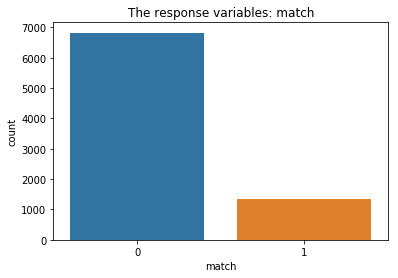

In [73]:
sns.countplot(diff['match'])
plt.title('The response variables: match')
plt.show()

Only 12% of the dates end up with a match. We have modeled based on this data but it is found that models created has high accuracy but low AUC. To deal with the unbalanced target variable, we will perform oversampling the minority group (match). And in order to make sure the consistancy of our result, we will split the data train, valid and test before our model building. Oversampling will only be done on train and valid data while we will use the test data to be our gatekeeper to ensure consistency when we feed unmodified data into the model.

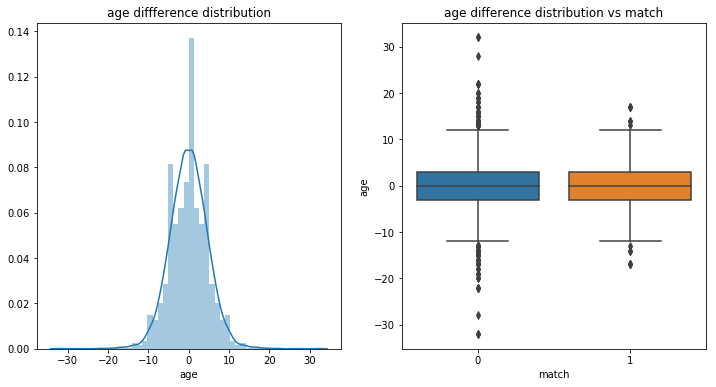

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.distplot(diff.age)
plt.title('age diffference distribution')
plt.subplot(122)
sns.boxplot(y = diff.age,x = diff.match)
plt.title('age difference distribution vs match')
plt.show()

The age difference between the participants and their partners is approximately normally distributed at 0. From the boxplot, age difference doesn't appears to have any significant different between match or not match.

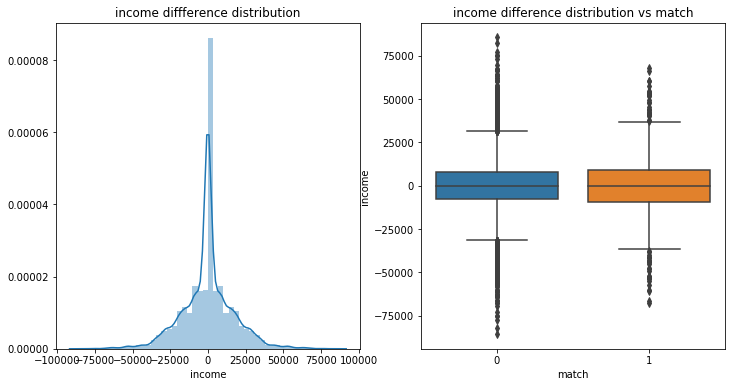

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.distplot(diff.income)
plt.title('income diffference distribution')
plt.subplot(122)
sns.boxplot(y = diff.income,x = diff.match)
plt.title('income difference distribution vs match')
plt.show()

Similarly, income difference between the participants and their partners is also approximately normally distributed. The boxplot shows pair did not match is more widely spreaded but there are no significant differences in median of income difference on whether the pairs is a match or not.

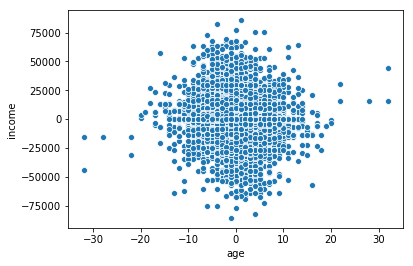

In [59]:
sns.scatterplot(diff.age,diff.income)
plt.show()

From the scatterplot, income difference and age difference are not correlated so it is safe for us to use them as predictors.

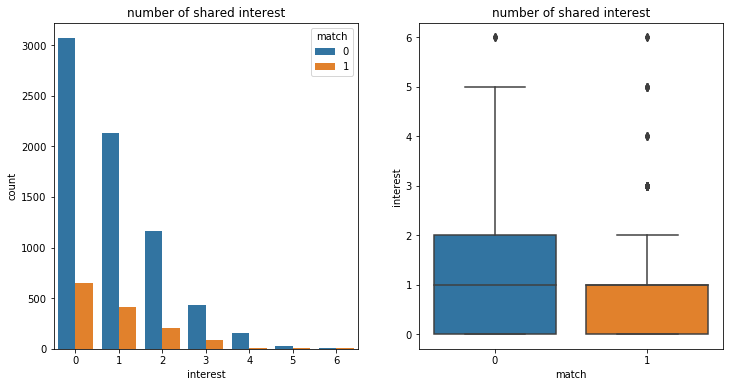

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.countplot(diff['interest'],hue=diff.match)
plt.title('number of shared interest')
plt.subplot(122)
sns.boxplot(y = diff.interest,x = diff.match)
plt.title('number of shared interest')
plt.show()

For above, we can see pairs ends up with a match generally shared less interest than pairs do not match.

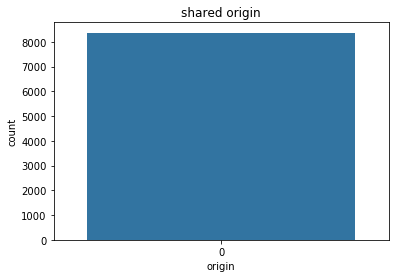

In [61]:
sns.countplot(diff['origin'])
plt.title('shared origin')
plt.show()

None of the pairs shared the same origin. Hence, the variable no longer useful and we will drop this variable in our model building.

# Model Building

In the coming section, we will use different algorithms to train the classification model to classify whether the speed dating pair will be a match to the participant. As mentioned earlier, we will split the data into 3 parts.

In [76]:
target = diff['match']
data = diff.drop(['match','origin'],axis=1)
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(data, target, random_state=123, train_size=0.8, test_size = 0.2)
diff_n = pd.concat([X,y],axis=1)

In [77]:
from sklearn.utils import resample
# Separate majority and minority classes
majority = diff_n[diff_n.match==0]
minority = diff_n[diff_n.match==1]
 
# Oversampleing majority class
resample = resample(minority, 
                    replace=True,    # sample without replacement
                    n_samples=int(diff_n.match.value_counts()[0]*0.7),     # to match minority class
                    random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
diff_n = pd.concat([resample, majority])
 
# Display new class counts
print("The processed dataset has response as follow: ")
print(diff_n.match.value_counts())

The processed dataset has response as follow: 
0    5454
1    3817
Name: match, dtype: int64


In [78]:
#creating data frame for target and features
target = diff_n['match']
data = diff_n.drop('match',axis=1)

In [79]:
#split the data
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(data, target, random_state=123, train_size=0.7,test_size=0.3)

In [80]:
# initialise lists to store the evaluation of different model
train_acc = []
train_auc = []
test_acc =[]
test_auc = []
valid_acc=[]
valid_auc=[]

### Logistic Regression
Logistic regression is estimating the parameters of a logistic model; it is a form of binomial regressiom. It took the predictors to estimate the probability of the response class.

In [67]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
lr_score = model_evaluation_score(logreg, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(lr_score['train_acc'])
train_auc.append(lr_score['train_auc'])
test_acc.append(lr_score['test_acc'])
test_auc.append(lr_score['test_auc'])
valid_acc.append(lr_score['valid_acc'])
valid_auc.append(lr_score['valid_auc'])

### K-nearest Neighbors (KNN)
In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. It calculate the 'how difference' the instance to the target class and classify based on which is the nearest class

In [86]:
# K-nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,10,1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    print(knn.score(X_valid,y_valid))

0.7818116462976276
0.7577282530553558
0.7199856218547808
0.688353702372394
0.677570093457944
0.6721782890007189
0.6660675772825305
0.6531272465851905
0.6419841840402588


In [87]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn_score = model_evaluation_score(knn, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(knn_score['train_acc'])
train_auc.append(knn_score['train_auc'])
test_acc.append(knn_score['test_acc'])
test_auc.append(knn_score['test_auc'])
valid_acc.append(knn_score['valid_acc'])
valid_auc.append(knn_score['valid_auc'])

### Naive Bayes

In machine learning, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features. We train the model based on the occurence of a certain feature in the prior observation and classify based on if that feature appears in the posterior observation.

In [69]:
# Gaussian Naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_score = model_evaluation_score(gnb, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(gnb_score['train_acc'])
train_auc.append(gnb_score['train_auc'])
test_acc.append(gnb_score['test_acc'])
test_auc.append(gnb_score['test_auc'])
valid_acc.append(gnb_score['valid_acc'])
valid_auc.append(gnb_score['valid_auc'])

### Neural Network
Neural Network used a simulation of neuron from the brain. It starts with assigning random weight in the calculation of probability of class that the observation belongs. And by readjusting the weight in different layers when it makes an error, the algorithm modified the weight automatically to give better result.

In [70]:
# Neural Network
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(10), alpha=0.0001, random_state=0)
mlpc.fit(X_train,y_train)
mlpc_score = model_evaluation_score(mlpc,X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(mlpc_score['train_acc'])
train_auc.append(mlpc_score['train_auc'])
test_acc.append(mlpc_score['test_acc'])
test_auc.append(mlpc_score['test_auc'])
valid_acc.append(mlpc_score['valid_acc'])
valid_auc.append(mlpc_score['valid_auc'])

### Decision Tree
A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility.

In [71]:
# Descision Treee
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0,min_samples_split=5)
dtree.fit(X_train, y_train)
dtree_score = model_evaluation_score(dtree, X_train,X_valid,X_test,y_train,y_valid,y_test)
train_acc.append(dtree_score['train_acc'])
train_auc.append(dtree_score['train_auc'])
test_acc.append(dtree_score['test_acc'])
test_auc.append(dtree_score['test_auc'])
valid_acc.append(dtree_score['valid_acc'])
valid_auc.append(dtree_score['valid_auc'])

After fitting different model, we create a data frame to display the Accuracy and AUC to mesure the performance of different models.

In [72]:
# Display the training and testing acc, auc
model = ['logreg','knn','gnb','nn','tree']
model_evaluation = pd.DataFrame({'model':model,
                                'train_acc':train_acc,
                                'train_auc':train_auc,
                                'valid_acc':valid_acc,
                                'valid_auc':valid_auc,
                                'test_acc':test_acc,
                                'test_auc':test_auc})
model_evaluation

,model,test_acc,test_auc,train_acc,train_auc,valid_acc,valid_auc
0,logreg,0.814815,0.502967,0.586388,0.516014,0.577638,0.509837
1,knn,0.689367,0.522166,0.884465,0.880473,0.781633,0.786512
2,gnb,0.830346,0.554100,0.589844,0.538257,0.583246,0.558830
3,nn,0.599164,0.529374,0.527644,0.513001,0.511742,0.499436
4,tree,0.685783,0.499833,0.890475,0.970450,0.767964,0.838165


Accuracy and AUC provide an indication how well the model classify the observation into target group. From the above table, knn and decision tree shows high accurary and auc (above 75%) in their training and validation stage. However, the auc drop sharply when we use the model to predict the test data. This indicated the model has been overfitting.

We have tried different ratio of over-sampling and down-sampling, but the AUC remained at around 50% which did not do better prediction than not having the model.

The reason of this is likely we did not capture the right features in our data. As we saw that from the data exloration did not have any difference in no matter the pairs match or not match.

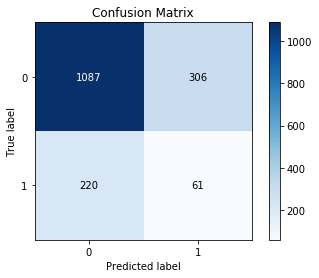

In [73]:
import scikitplot as skplt
predicted_test = dtree.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, predicted_test)
plt.show()

The confusion matrix provide information what are the false positive and false negative the model is making. As seen above, The model tends to predict the majority(not match) class right but can hardly classified match.

In [74]:
#feature importance
from sklearn.feature_selection import RFE
selector = RFE(dtree, 1, step=1)
selector = selector.fit(X_train, y_train)
print(X_train.columns)
print(selector.ranking_)

Index(['age', 'field_cd', 'go_out', 'income', 'interest', 'race'], dtype='object')
[2 6 5 1 3 4]


Income is found to be the most important variables with age come second. The importance of these two features can also be seen in the Decision Tree Plot below. The tree splits based on income and age in first two levels of split.

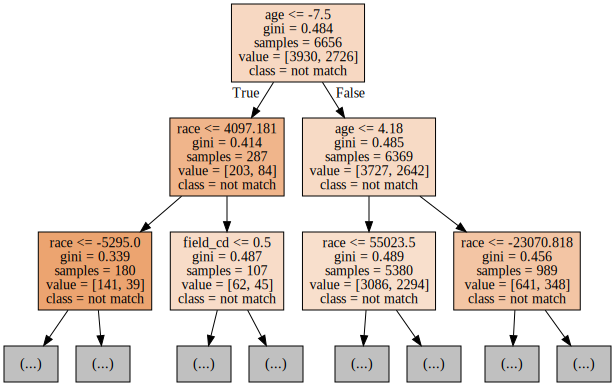

In [75]:
# Visualize the decision Tree
from sklearn import tree
import graphviz 
import pydotplus
dtree = dtree.fit(X_train, y_train)
dot_data = tree.export_graphviz(dtree, out_file=None,max_depth = 2,
                                feature_names = ['age', 'go_out', 'income', 'race','field_cd','interest'], class_names=['not match','match'],
                               filled = True) 
graph = graphviz.Source(dot_data) 
graph

# Summary and future improvement

To conclude, our project aim to provide indication for speed dating event host to group people that share common interest or more likely to find each other match their partner selection criteria.

We trained a **Speed Dating Match Classifier** that classify if a pair of partificant will result a match in a speed dating event. Interest and age is the most important feature. Decision Tree gave the best performance among all other algorithm used with train accuracy and auc and validation accuracy and auc over 75%. However, the model is over fitted as AUC dropped rapidly when we tried to predict with the test data. This indicated the model created is unreliable.

This may caused by serveral reasons:
- the sample size is not large enough to represent the population
- variables in profile is not the right feature for the classification, we can extend the model by using the selection criteria questionaire result
- the original paper of the speed dating data also suggested male and female has different selection criteria, our model did not specified this. We may improve the model by spliting the model into two for male and female.


# Reference
Relationship Australia, 2017:https://www.relationships.org.au/what-we-do/research/online-survey/november-2017-online-dating